In [1]:
import tensorflow as tf
import IPython
import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

!pip install mitdeeplearning
import mitdeeplearning as mdl

     |████████████████████████████████| 2.1 MB 893 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115442 sha256=d9efe754149a5584c71443319a920258c643ff670e8eed2b7ed630d1f1cf5d2e
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning


In [2]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5',
                                                'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

1263902720/1263889489 [==============================] - 25s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


We can look at the size of the training dataset and grab a batch of size 100:

In [3]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

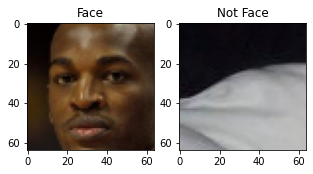

In [4]:
### Examining the CelebA training dataset ###

#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 23 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 6 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

In [5]:
### Define the CNN model ###

n_filters = 12 

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

2022-07-22 05:58:50.949670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 05:58:51.076965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 05:58:51.077728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 05:58:51.078922: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

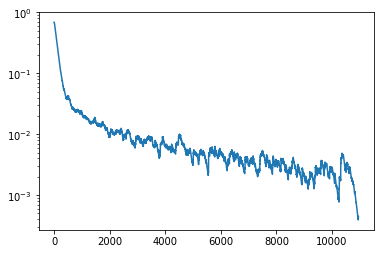

100%|██████████| 1099/1099 [00:18<00:00, 60.56it/s]


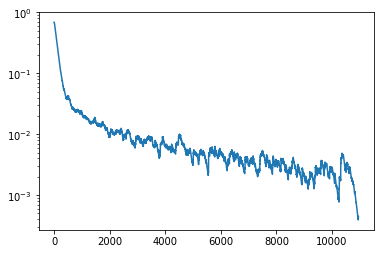

In [6]:
### Train the standard CNN ###

# Training hyperparameters
batch_size = 100
num_epochs = 10  # keep small to run faster
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x) 
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop!
for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

In [7]:
### Evaluation of standard CNN ###

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

Standard CNN accuracy on (potentially biased) training set: 1.0000


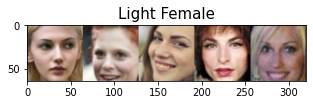

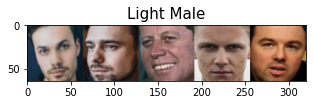

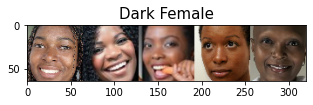

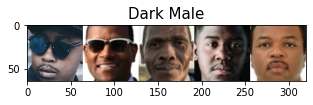

In [8]:
### Load test dataset and plot examples ###

test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces,keys): 
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize=15)

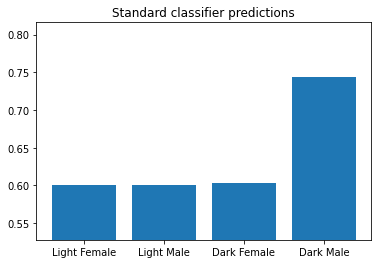

In [9]:
### Evaluate the standard CNN on the test data ### 

standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Standard classifier predictions");

In [10]:
print('Precision in prediction without resampling technique', yy.mean())
print('Bias in prediction without resampling technique', (yy*100).var())

Precision in prediction without resampling technique 0.6369413
Bias in prediction without resampling technique 38.3282


In [11]:
### Defining the VAE loss function ###

''' Function to calculate VAE loss given:
      an input x, 
      reconstructed output x_recon, 
      encoded means mu, 
      encoded log of standard deviation logsigma, 
      weight parameter for the latent loss kl_weight
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  # TODO: Define the latent loss. Note this is given in the equation for L_{KL}
  # in the text block directly above
  latent_loss = tf.reduce_sum(tf.math.exp(logsigma) + mu**2 - 1.0 - logsigma, axis=[-1])/2

  # TODO: Define the reconstruction loss as the mean absolute pixel-wise 
  # difference between the input and reconstruction. Hint: you'll need to 
  # use tf.reduce_mean, and supply an axis argument which specifies which 
  # dimensions to reduce over. For example, reconstruction loss needs to average 
  # over the height, width, and channel image dimensions.
  # https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), [-1,-2,-3])

  # TODO: Define the VAE loss. Note this is given in the equation for L_{VAE}
  # in the text block directly above
  vae_loss = kl_weight*latent_loss + reconstruction_loss
  return vae_loss

In [12]:
### VAE Reparameterization ###

"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
    z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  # TODO: Define the reparameterization computation!
  # Note the equation is given in the text block immediately above.
  z = z_mean + tf.math.exp(0.5*(z_logsigma)) * epsilon
  return z

In [13]:
### Loss function for DB-VAE ###

"""Loss function for DB-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: DB-VAE total loss
    classification_loss = DB-VAE classification loss
"""
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma, beta):

  # TODO: call the relevant function to obtain VAE loss
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma, beta) # TODO
 
  # TODO: define the classification loss using sigmoid_cross_entropy
  # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)

  # Use the training data labels to create variable face_indicator:
  #   indicator that reflects which training data are images of faces
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  # TODO: define the DB-VAE total loss! Use tf.reduce_mean to average over all
  # samples
  total_loss = tf.squeeze(classification_loss) + tf.squeeze(face_indicator)*vae_loss
  return total_loss, classification_loss

In [14]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network():
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

In [15]:
### Defining and creating the DB-VAE ###

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have 
    # `latent_dim` latent variables, as well as a supervised output for the 
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability 
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1] 
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    # TODO: call the sampling function defined above
    z = sampling(z_mean, z_logsigma)
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):
    # TODO: use the decoder to output the reconstruction
    reconstruction = self.decoder(z)
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x): 
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    # TODO: reparameterization
    z = self.reparameterize(z_mean, z_logsigma)

    # TODO: reconstruction
    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

In [16]:
# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

In [17]:
### Resampling algorithm for DB-VAE ###

'''Function that recomputes the sampling probabilities for images within a batch
      based on how they distribute across the training data'''
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001): 
    print("Recomputing the sampling probabilities")
    
    # TODO: run the input batch and get the latent variable means
    mu = get_latent_mu(images, dbvae) # TODO
    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])
    
    # consider the distribution for each latent variable 
    for i in range(latent_dim):
      
        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)
#         print(latent)
        # find which latent bin every data sample falls in 
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        
        # TODO: call the digitize function to find which bins in the latent distribution 
        #    every data sample falls in to
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_idx = np.digitize(latent_distribution, bin_edges) # TODO

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # invert the density function 
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        
        # TODO: normalize all probabilities
        p /= np.sum(p)
        
        # TODO: update sampling probabilities by considering whether the newly
        #     computed p is greater than the existing sampling probabilities.
        training_sample_p = np.maximum(training_sample_p, p)
        
    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Starting epoch 15/15
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

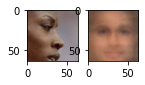

 14%|█▍        | 495/3434 [00:04<00:23, 124.69it/s]

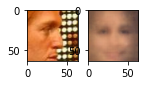

 29%|██▉       | 988/3434 [00:08<00:19, 125.21it/s]

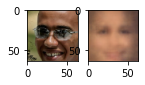

 44%|████▎     | 1495/3434 [00:12<00:15, 124.10it/s]

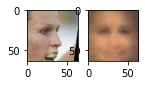

 58%|█████▊    | 2000/3434 [00:17<00:11, 123.63it/s]

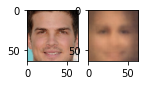

 73%|███████▎  | 2494/3434 [00:21<00:09, 98.33it/s]

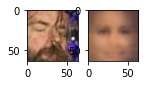

 87%|████████▋ | 2998/3434 [00:26<00:03, 123.76it/s]

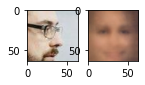

100%|██████████| 3434/3434 [00:30<00:00, 113.94it/s]

CPU times: user 2h 45min 11s, sys: 14min 34s, total: 2h 59min 45s
Wall time: 2h 53min 16s


In [18]:
%%time
### Training the DB-VAE ###
# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 100

# DB-VAE needs slightly more epochs to train since its more complex than 
# the standard classifier so we use 6 instead of 2
num_epochs = 15
alphas = [1, 0.1, 0.01, 0.001]
dbvae_probs = []
betas = [0.0005, 1, 10, 150, 300]
# instantiate a new DB-VAE model and optimizer
for beta in betas:
    dbvae_probs.append([])
    for alpha in alphas:
        dbvae = DB_VAE(100)
        optimizer = tf.keras.optimizers.Adam(learning_rate)

        # To define the training operation, we will use tf.function which is a powerful tool 
        #   that lets us turn a Python function into a TensorFlow computation graph.
        @tf.function
        def debiasing_train_step(x, y):

          with tf.GradientTape() as tape:
            # Feed input x into dbvae. Note that this is using the DB_VAE call function!
            y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

            '''TODO: call the DB_VAE loss function to compute the loss'''
            loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma, beta) # TODO

          '''TODO: use the GradientTape.gradient method to compute the gradients.
             Hint: this is with respect to the trainable_variables of the dbvae.'''
          grads = tape.gradient(loss, dbvae.trainable_variables) # TODO

          # apply gradients to variables
          optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
          return loss

        # get training faces from data loader
        all_faces = loader.get_all_train_faces()

        if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

        # The training loop -- outer loop iterates over the number of epochs
        for i in range(num_epochs):

          IPython.display.clear_output(wait=True)
          print("Starting epoch {}/{}".format(i+1, num_epochs))

          # Recompute data sampling proabilities
          '''TODO: recompute the sampling probabilities for debiasing'''
          p_faces = get_training_sample_probabilities(all_faces, dbvae, smoothing_fac=alpha) # TODO

          # get a batch of training data and compute the training step
          for j in tqdm(range(loader.get_train_size() // batch_size)):
            # load a batch of data
            (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
            # loss optimization
            loss = debiasing_train_step(x, y)

            # plot the progress every 200 steps
            if j % 500 == 0: 
              mdl.util.plot_sample(x, y, dbvae)
        dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
        dbvae_probs[-1].append(tf.squeeze(tf.sigmoid(dbvae_logits)).numpy().mean(1))


In [19]:
import seaborn as sns

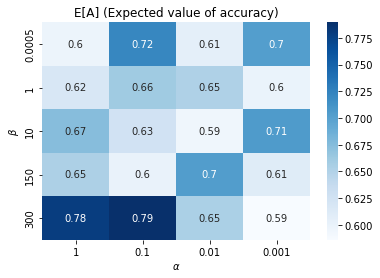

In [20]:
sns.heatmap(np.asarray(dbvae_probs).mean(axis=-1), xticklabels=alphas, yticklabels=betas, annot=True, cmap='Blues')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('E[A] (Expected value of accuracy)')
plt.show()

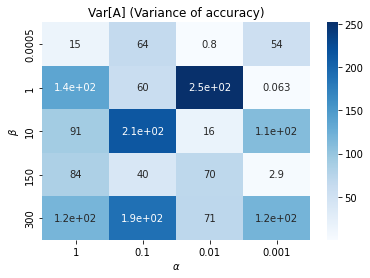

In [21]:
sns.heatmap(np.asarray(dbvae_probs).var(axis=-1)*10**4, xticklabels=alphas, yticklabels=betas, annot=True, cmap='Blues')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('Var[A] (Variance of accuracy)')
plt.show()

In [22]:
# db = np.hstack((np.asarray(dbvae_probs), np.asarray(dbvae_probs).mean(1, keepdims=True)))
# plt.figure(figsize=(12, 4))
# xx = np.arange(len(keys)+1)
# width = 0.1
# for idx, alpha in enumerate(alphas):
#     plt.bar(xx + (idx-2)*width, db[idx], label=str(alpha), width=width)
# # plt.bar(xx + (idx-2)*width +1, np.asarray(dbvae_probs).mean(0), label=str(alpha), width=width)
# plt.xticks(xx, keys + ['overall'])
# plt.legend(title='alpha', ncol=5)
# plt.ylim([0,1])
# plt.show()

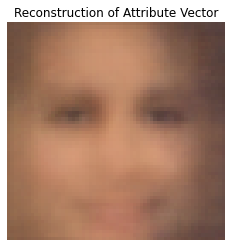

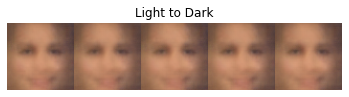

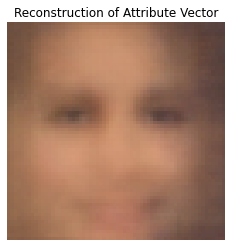

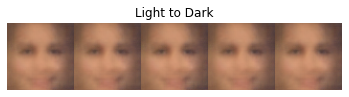

In [23]:
light_females, light_males, dark_females, dark_males = test_faces
def plot_variation_in_physical_feature(light, dark):
    _, light_mean, light_logsigma = dbvae.encode(np.asarray(light))
    _, dark_mean, dark_logsigma = dbvae.encode(np.asarray(dark))
    attribute_vector_mean = np.mean(light_mean, axis=0, keepdims=True)\
                            - np.mean(dark_mean, axis=0, keepdims=True)
    plt.figure()
    plt.imshow(np.squeeze(dbvae.decode(attribute_vector_mean)))
    plt.title('Reconstruction of Attribute Vector')
    plt.axis('off')
    plt.show()
    
    _, z, z_logsigma = dbvae.encode(np.expand_dims(light[0], 0))
    z = np.repeat(z,5,axis=0) + ((1.0-np.linspace(0,1.5,5).reshape(5,1))*attribute_vector_mean)
    z_logsigma = np.repeat(z_logsigma, 5, axis=0)
    z_reparameterized = dbvae.reparameterize(z, z_logsigma)
    reconstructed = dbvae.decode(z_reparameterized)
    
    plt.figure()
    plt.imshow(np.hstack(reconstructed))
    plt.title('Light to Dark')
    plt.axis('off')
    plt.show()
    
plot_variation_in_physical_feature(light_females, dark_females)
plot_variation_in_physical_feature(light_males, dark_males)

In [24]:
p_faces = get_training_sample_probabilities(all_faces, dbvae)

Recomputing the sampling probabilities


In [25]:
# freq, bin_edges = np.histogram(p_faces)
# freq = np.log(freq)
# plt.figure(figsize=(16,4))
# ax = plt.gca()
# ax.set_xlim(0,400)
# ax.set_ylim(0,100)
# xscale = 400/(max(bin_edges)-min(bin_edges))
# yscale = 75/(max(freq)-min(freq))
# x_midpoints = ((np.roll(bin_edges, 1) + bin_edges)/2)[1:]

# for i in range(len(bin_edges)-1):
#     condition = (p_faces > bin_edges[i]) & (p_faces < bin_edges[i+1])
#     if sum(condition)>=4:
#         samples = all_faces[condition][:4]
#         samples = np.vstack((np.hstack((samples[0],samples[1])), np.hstack((samples[2],samples[3]))))
#         plt.imshow(samples[:,:,::-1], extent=((bin_edges[i]-bin_edges[0])*xscale+2, (bin_edges[i+1]-bin_edges[0])*xscale-2, 80, 99))
#     else:
#         pass
# plt.bar((x_midpoints-bin_edges[0])*xscale, yscale*(freq-min(freq)), width=10)
# plt.xticks((bin_edges-min(bin_edges))*xscale, [format(x)[:4] + format(x)[-4:] for x in bin_edges])
# # plt.gca().ticklabel_format(axis='x', style="sci", scilimits=(0,0))
# plt.yticks((np.arange(1,np.round(max(freq))+1,2)-min(freq))*yscale, np.arange(1,np.round(max(freq))+1,2))
# plt.xlabel('Probability')
# plt.ylabel('log(Frequency)')
# plt.show()

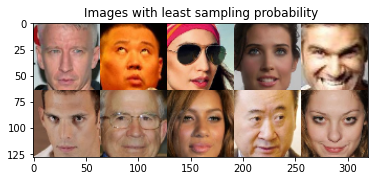

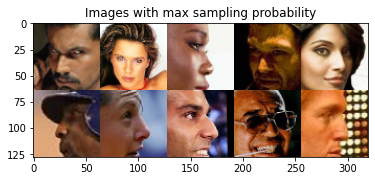

In [26]:
least_probab = all_faces[np.argsort(p_faces)[:10]]
max_probab = all_faces[np.argsort(p_faces)[-10:]]
plt.imshow(np.vstack([np.hstack([image for image in least_probab[:5]]), np.hstack([image for image in least_probab[5:10]])])[:,:,::-1])
plt.title('Images with least sampling probability')
plt.show()
plt.imshow(np.vstack([np.hstack([image for image in max_probab[:5]]), np.hstack([image for image in max_probab[5:10]])])[:,:,::-1])
plt.title('Images with max sampling probability')
plt.show()

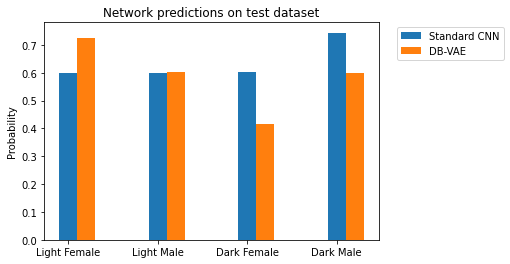

In [27]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys); 
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");
